In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("student-data.csv")
pd.set_option('display.max_columns', None)

395

In [3]:
def preprocess(data):
    out = pd.DataFrame(index = data.index)
    for col,col_data in data.iteritems():
        if col_data.dtype == object:
            col_data = col_data.replace(['yes','no'],[1,0]) 
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data,prefix=col)
        out = out.join(col_data)
    return out

In [4]:
data = preprocess(data)
feature_list = data.columns[:-1]
targets = data.columns[-1]
X = data[feature_list]
y = data[targets]
X = X.values
y = y.values

In [5]:
from sklearn.preprocessing import MinMaxScaler
sclr = MinMaxScaler()
X_new = X
X_new[:,4] = sclr.fit_transform(X[:,4].reshape(-1,1)).reshape(-1)
X_new[:,-1] = sclr.fit_transform(X[:,-1].reshape(-1,1)).reshape(-1)

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.learning_curve import learning_curve
from sklearn.svm import SVC
%matplotlib inline
from matplotlib import pylab

In [7]:
def plot_curve(clf,X,y,metric="f1",cv_size=0.25):
    cv = StratifiedShuffleSplit(y,test_size=cv_size,random_state=42)
    train_size,train_score,test_score = learning_curve(clf,X,y,scoring=metric,cv=cv)
    test_mean = np.mean(test_score,axis=1)
    test_dev = np.std(test_score,axis=1)
    train_mean = np.mean(train_score,axis=1)
    train_dev = np.std(train_score,axis=1)
    print test_mean[-1], train_mean[-1]
    pylab.plot(train_size,train_mean,label="train")
    pylab.fill_between(train_size, train_mean - train_dev,train_mean + train_dev, alpha=0.1,color="r")
    pylab.plot(train_size,test_mean,label="test")
    pylab.fill_between(train_size, test_mean - test_dev,test_mean + test_dev, alpha=0.1,color="r")
    pylab.grid()
    pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pylab.title(clf.__class__.__name__)
    #pylab.show()
    

In [8]:
NBclf = MultinomialNB()
SVclf = SVC()
LRclf = LogisticRegression()

In [23]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.24,random_state=18)

In [44]:
import time
def train_clf(clf,X_train,y_train):
    #print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    #print "Done!\nTraining time (secs): {:.3f}".format(end - start)
    return end-start

In [45]:
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    #print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    #print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return end-start,f1_score(target, y_pred, pos_label=1)

In [46]:
def train_predict(clf, X_train, y_train, X_test, y_test):
    #print "------------------------------------------"
    #print "Training set size: {}".format(len(X_train))
    train_time = train_clf(clf, X_train, y_train)
    #print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train))
    #print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))
    predict_train_time,predict_train_score = predict_labels(clf, X_train, y_train)
    predict_test_time,predict_test_score = predict_labels(clf, X_test, y_test)
    return {"classifier":clf.__class__.__name__,"train_size":len(X_train),"training_time":train_time,
            "Predict_train_time":predict_train_time,"predict_train_score":predict_train_score,
            "predict_test_time":predict_test_time,"predict_test_score":predict_test_score}

In [124]:
perf = []
for size in [100,200,300]:
        perf.append(train_predict(clf, X_train[:size], y_train[:size], X_test, y_test))
Allclf = pd.DataFrame(perf)

TypeError: list indices must be integers, not str

In [119]:
MultinomialNB_perf = Allclf[Allclf.classifier=="MultinomialNB"]
LogisticReg_perf = Allclf[Allclf.classifier=="LogisticRegression"]
SVC_perf = Allclf[Allclf.classifier=="SVC"]

In [120]:
MultinomialNB_perf

,Predict_train_time,classifier,predict_test_score,predict_test_time,predict_train_score,training_time
train_size,,,,,,
100,0.000136,MultinomialNB,0.855263,0.000105,0.794118,0.001508
200,0.000114,MultinomialNB,0.866242,0.000100,0.825503,0.001205
300,0.000115,MultinomialNB,0.864516,0.000093,0.797235,0.001200


In [83]:
SVC_perf

,Predict_train_time,classifier,predict_test_score,predict_test_time,predict_train_score,train_size,training_time
0,0.000948,SVC,0.841463,0.000892,0.782609,100,0.001455
1,0.003824,SVC,0.846626,0.002317,0.824242,200,0.004054
2,0.009631,SVC,0.867925,0.001943,0.817021,300,0.011518


In [84]:
LogisticReg_perf

,Predict_train_time,classifier,predict_test_score,predict_test_time,predict_train_score,train_size,training_time
0,0.000119,LogisticRegression,0.824324,0.000069,0.848485,100,0.000808
1,0.000086,LogisticRegression,0.818182,0.000065,0.847458,200,0.001457
2,0.000098,LogisticRegression,0.829932,0.000064,0.823256,300,0.001954


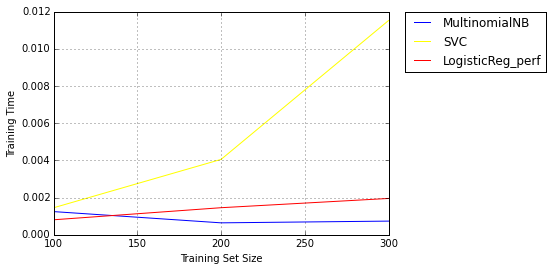

In [88]:
pylab.plot(MultinomialNB_perf.train_size,MultinomialNB_perf.training_time,color="Blue",label="MultinomialNB")
pylab.plot(SVC_perf.train_size,SVC_perf.training_time,color="Yellow",label="SVC")
pylab.plot(LogisticReg_perf.train_size,LogisticReg_perf.training_time,color="Red",label="LogisticReg_perf")
pylab.grid()
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.xlabel("Training Set Size")
pylab.ylabel("Training Time")
pylab.show()

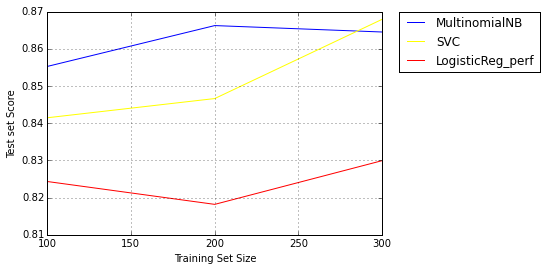

In [89]:
pylab.plot(MultinomialNB_perf.train_size,MultinomialNB_perf.predict_test_score,color="Blue",label="MultinomialNB")
pylab.plot(SVC_perf.train_size,SVC_perf.predict_test_score,color="Yellow",label="SVC")
pylab.plot(LogisticReg_perf.train_size,LogisticReg_perf.predict_test_score,color="Red",label="LogisticReg_perf")
pylab.grid()
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.xlabel("Training Set Size")
pylab.ylabel("Test set Score")
pylab.show()

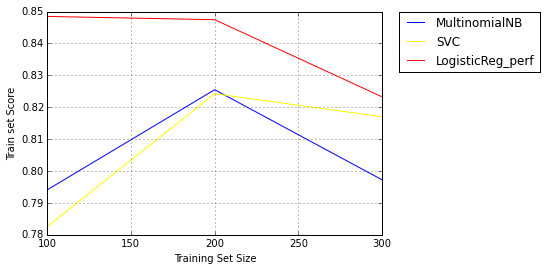

In [91]:
pylab.plot(MultinomialNB_perf.train_size,MultinomialNB_perf.predict_train_score,color="Blue",label="MultinomialNB")
pylab.plot(SVC_perf.train_size,SVC_perf.predict_train_score,color="Yellow",label="SVC")
pylab.plot(LogisticReg_perf.train_size,LogisticReg_perf.predict_train_score,color="Red",label="LogisticReg_perf")
pylab.grid()
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.xlabel("Training Set Size")
pylab.ylabel("Train set Score")
pylab.show()

In [107]:
def plotter(data,**kwargs):
    if kwargs is not None:
        pylab.plot(data.)

In [108]:
plotter(10,a="train_size")

train_size


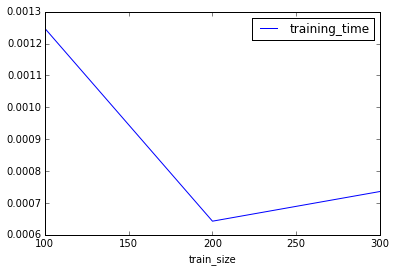

In [114]:
MultinomialNB_perf.set_index("train_size",inplace=True)
MultinomialNB_perf[["training_time"]].plot()

In [113]:
MultinomialNB_perf.index

Int64Index([0, 1, 2], dtype='int64')